In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [2]:
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 6GB Laptop GPU
Using device: cuda


In [3]:
new_df = pd.read_csv('sentiment_scored_.csv')

In [4]:
new_df = new_df.sort_values(by='timestamp')

In [5]:
new_df.drop(columns=['Unnamed: 0'],inplace=True)

In [6]:
new_df.head()

,rating,text,timestamp,rob_neg,rob_neu,rob_pos
11566,4,Easy to use. Non invasive. Vibrates with resul...,2018-05-11 17:21:49.173,0.013828,0.014668,0.971504
15082,5,This is the easiest thermometer that gives the...,2018-05-12 18:36:23.059,0.014745,0.014590,0.970665
1903,5,Easy to use. Easy to read display. Light weigh...,2018-05-13 00:28:58.218,0.016857,0.024825,0.958318
15180,4,I like that you don't touch the skin; that it ...,2018-05-24 16:19:08.822,0.082151,0.121618,0.796231
15771,4,My only complaint is that it does not work wit...,2018-05-24 17:02:23.110,0.057362,0.056420,0.886218


### Performing Moving Average

In [7]:
new_df['timestamp'] = pd.to_datetime(new_df['timestamp'], errors='coerce')

In [8]:
new_df['moving_average_neg'] = new_df['rob_neg'].rolling(window=30, min_periods=1).mean()
new_df['moving_average_neu'] = new_df['rob_neu'].rolling(window=30, min_periods=1).mean()
new_df['moving_average_pos'] = new_df['rob_pos'].rolling(window=30, min_periods=1).mean()

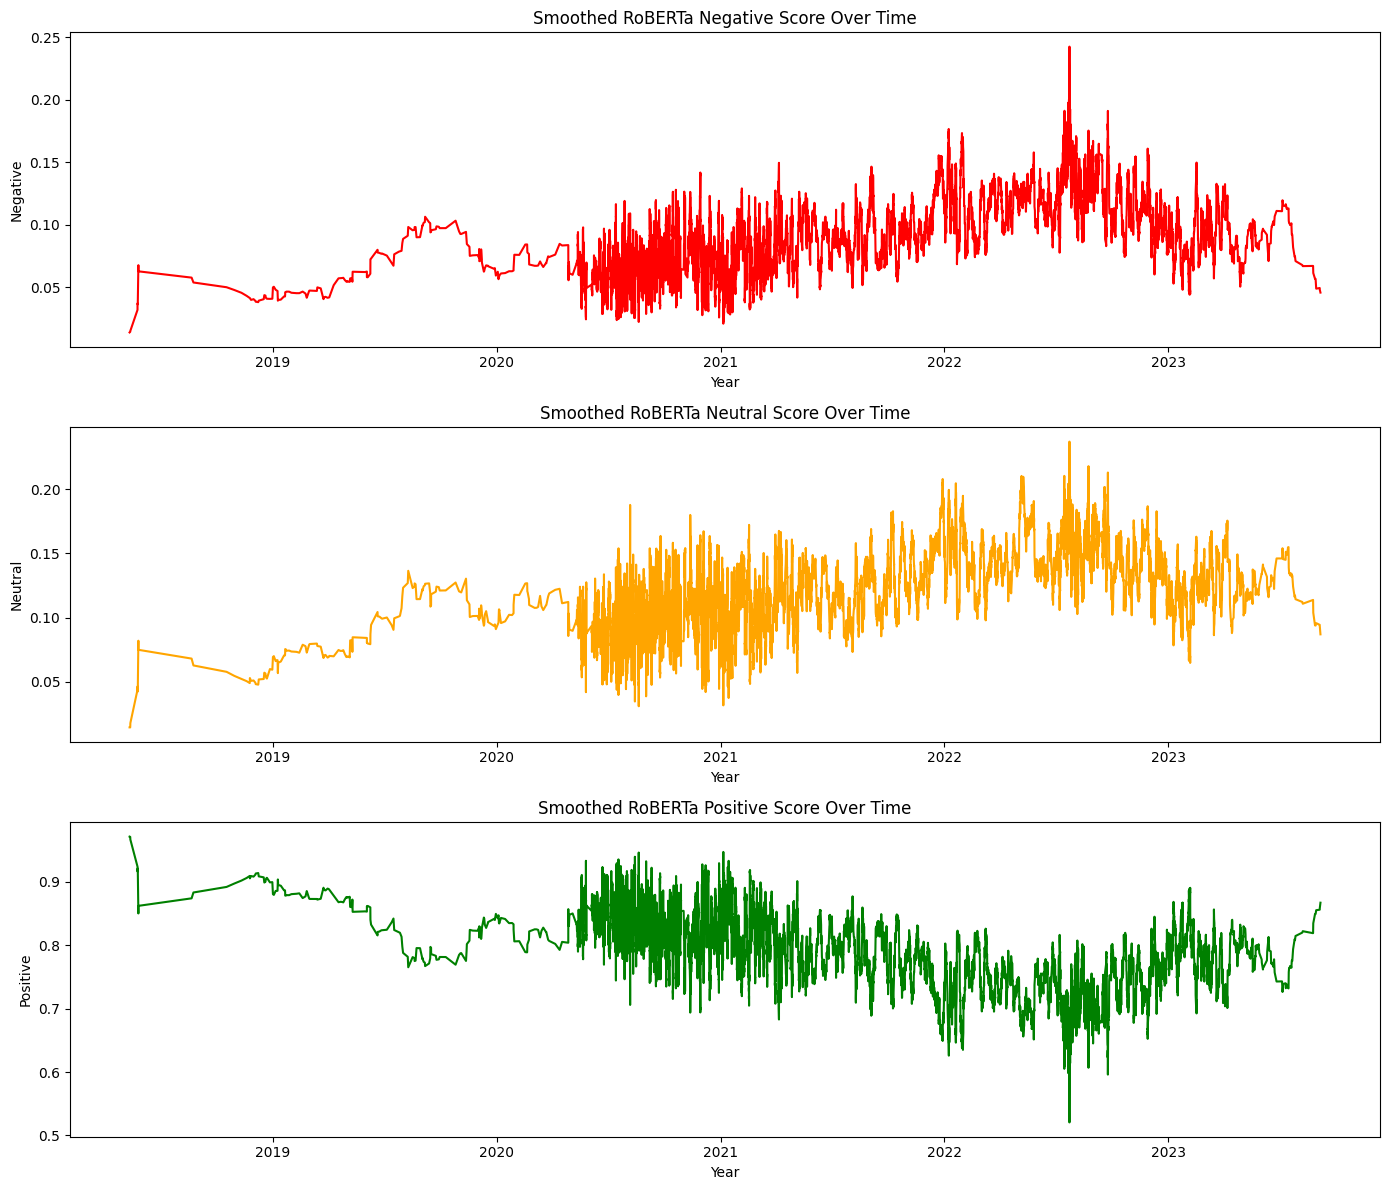

In [9]:
fig, arr = plt.subplots(3, 1, figsize=(14, 12))

arr[0].plot(new_df['timestamp'], new_df['moving_average_neg'], color='red')
arr[0].set_title("Smoothed RoBERTa Negative Score Over Time")
arr[0].set_ylabel("Negative")
arr[0].set_xlabel("Year")

arr[1].plot(new_df['timestamp'], new_df['moving_average_neu'], color='orange')
arr[1].set_title("Smoothed RoBERTa Neutral Score Over Time")
arr[1].set_ylabel("Neutral")
arr[1].set_xlabel("Year")

arr[2].plot(new_df['timestamp'], new_df['moving_average_pos'], color='green')
arr[2].set_title("Smoothed RoBERTa Positive Score Over Time")
arr[2].set_ylabel("Positive")
arr[2].set_xlabel("Year")

plt.tight_layout()
plt.show()


In [10]:
class Forecast_Sentiments:
    
    def __init__(self):
        self.WINDOW_SIZE = 180
        self.X = None
        self.y = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.cp = None
        self.model1 = None
        self.history = None
        self.best_model = None
        self.pos_result = None
        self.earlystopping = EarlyStopping( 
                            monitor="val_loss",
                            patience=1,
                            verbose=1,
                            mode="min",)
    
    def df_to_X_y(self,df,window_Size = 180):
        df_as_numpy = df.to_numpy()
        X = []
        y = []
        for i in tqdm(range(len(df_as_numpy) - window_Size)):
            row = [[a] for a in df_as_numpy[i:i + window_Size]]
            X.append(row)
            label = df_as_numpy[i + window_Size]
            y.append(label)

        self.X = np.array(X)
        self.y = np.array(y)
    
    def split_data_points(self,size = 12000):
        self.X_train , self.y_train = np.array(self.X[:size]), np.array(self.y[:size])
        self.X_test , self.y_test = np.array(self.X[size:]) , np.array(self.y[size:])
        
    
    def train_stacked_lstm_model(self, learning_rate=0.001):
        self.model1 = Sequential()
        self.model1.add(InputLayer((self.WINDOW_SIZE, 1)))

        self.model1.add(LSTM(64, return_sequences=True))
        self.model1.add(Dropout(0.2))

        self.model1.add(LSTM(64, return_sequences=True))
        self.model1.add(Dropout(0.2))

        self.model1.add(LSTM(64))
        self.model1.add(Dropout(0.2))

        self.model1.add(Dense(8, activation='relu'))
        self.model1.add(Dense(1, activation='linear'))

        self.model1.summary()

        self.cp = ModelCheckpoint('model1_best.keras', save_best_only=True)

        self.model1.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=learning_rate),metrics=[RootMeanSquaredError()])
        
    def fit_model(self,epochs = 50):
        self.history = self.model1.fit(
        self.X_train,
        self.y_train,
        validation_split=0.2,
        epochs=epochs,
        callbacks=[self.cp, self.earlystopping]
        )

        plt.figure(figsize=(10, 5))
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Training vs Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
            
        
        
    
    def forecast_model(self):
        self.best_model = load_model('model1_best.keras')
        temp = self.best_model.predict(self.X_test)
        return pd.DataFrame(data = {'Test Prediction' : temp.flatten(),'Actual' : self.y_test})
        
    
    def evaluation(self,model):
        
        mse = mean_squared_error(model['Test Prediction'],model['Actual'])
        rmse = np.sqrt(mse)
        r2 = r2_score(model['Test Prediction'],model['Actual'])
        mae = mean_absolute_error(model['Test Prediction'],model['Actual'])

        print('mse : ',mse)
        print('rmse : ',rmse)
        print('r2 : ',r2)
        print('mae : ',mae)
        
        
    def forecast_visual(self,model,text):
        plt.figure(figsize=(12, 5))

        plt.plot(model['Test Prediction'], color='blue', label='Predicted')
        plt.plot(model['Actual'], color='red', label='Actual')

        plt.title(f'{text} Sentiment Model Prediction vs Actual Values')
        plt.xlabel('Time Step')
        plt.ylabel('Sentiment Score')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
    

In [11]:
negative_sentiment = Forecast_Sentiments()
neutral_sentiment = Forecast_Sentiments()
positive_sentiment = Forecast_Sentiments()


### Peforming Model For Negative Sentiment

In [12]:
negative_sentiment.df_to_X_y(new_df['moving_average_neg'])

100%|██████████| 16677/16677 [00:01<00:00, 9981.04it/s]


In [13]:
negative_sentiment.split_data_points()

In [14]:
negative_sentiment.train_stacked_lstm_model(learning_rate=0.001)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 180, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 180, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 180, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 180, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,473 (326.07 KB)

 Trainable params: 83,473 (326.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - loss: 5.4788e-04 - root_mean_squared_error: 0.0217 - val_loss: 1.0267e-04 - val_root_mean_squared_error: 0.0101
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - loss: 7.9023e-05 - root_mean_squared_error: 0.0089 - val_loss: 9.0101e-05 - val_root_mean_squared_error: 0.0095
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - loss: 6.0613e-05 - root_mean_squared_error: 0.0078 - val_loss: 6.0290e-05 - val_root_mean_squared_error: 0.0078
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - loss: 4.7148e-05 - root_mean_squared_error: 0.0069 - val_loss: 4.7131e-05 - val_root_mean_squared_error: 0.0069
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - loss: 3.8577e-05 - root_mean_squared_error: 0.0062 - val_loss: 3.8890e-05 - val_root_mean_squared_error: 0.0062
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - loss: 3.2050e-05 - root_mean_squared_error: 0.0057 - val_loss: 3.8057e-05 - val_root_mean_squared_error:

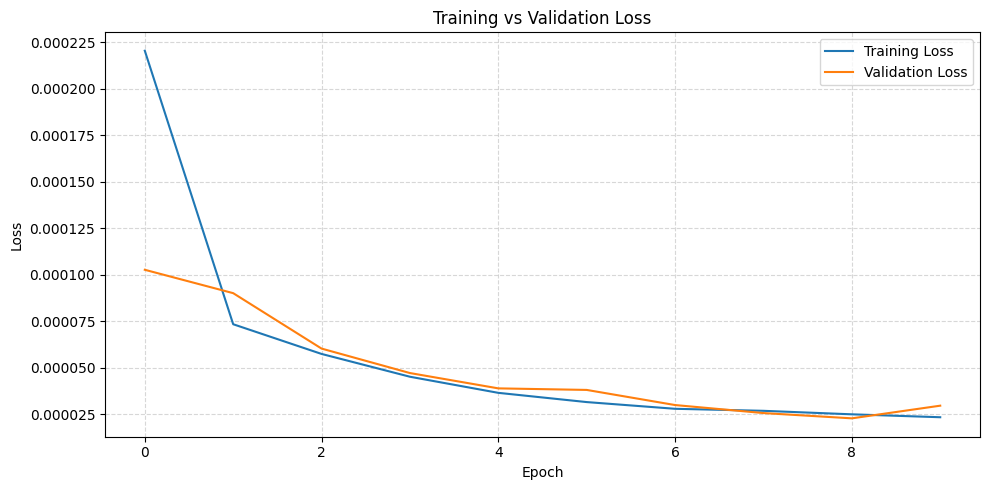

In [15]:
negative_sentiment.fit_model()

In [16]:
negative_sentiment_model = negative_sentiment.forecast_model()

147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step


In [17]:
negative_sentiment.evaluation(negative_sentiment_model)

mse :  3.146688445688325e-05
rmse :  0.005609535137324951
r2 :  0.9557692102277368
mae :  0.004332494660095513


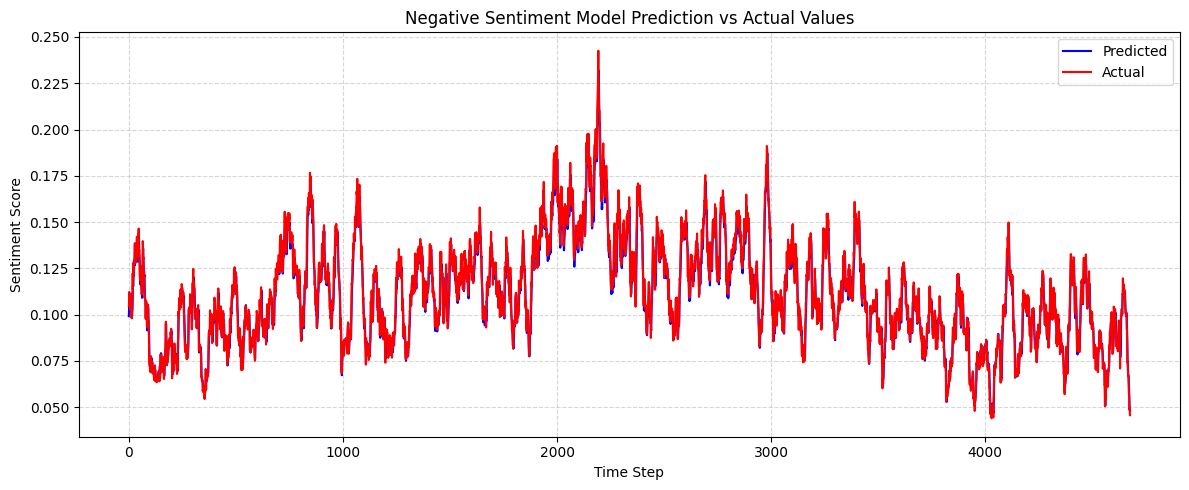

In [18]:
negative_sentiment.forecast_visual(negative_sentiment_model,text = 'Negative')

### Peforming Model For Positive Sentiment

In [19]:
positive_sentiment.df_to_X_y(new_df['moving_average_pos'])

100%|██████████| 16677/16677 [00:01<00:00, 8649.05it/s]


In [20]:
positive_sentiment.split_data_points()

In [21]:
positive_sentiment.train_stacked_lstm_model(learning_rate=0.0001)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 180, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 180, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 180, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 180, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,473 (326.07 KB)

 Trainable params: 83,473 (326.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 81ms/step - loss: 0.1711 - root_mean_squared_error: 0.3819 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0324
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - loss: 0.0057 - root_mean_squared_error: 0.0757 - val_loss: 9.5583e-04 - val_root_mean_squared_error: 0.0309
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - loss: 0.0051 - root_mean_squared_error: 0.0713 - val_loss: 9.9971e-04 - val_root_mean_squared_error: 0.0316
Epoch 4: early stopping


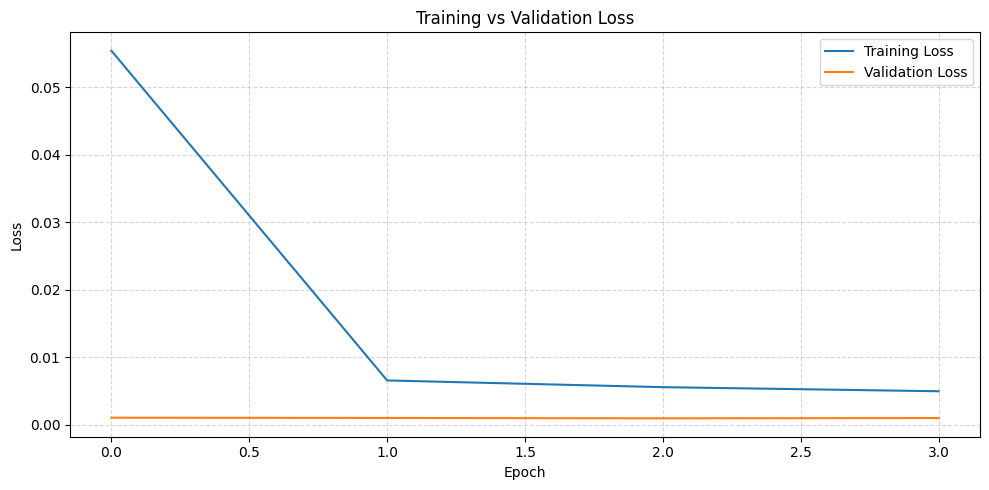

In [22]:
positive_sentiment.fit_model()

In [23]:
positive_sentiment_model = positive_sentiment.forecast_model()

147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step


In [24]:
positive_sentiment.evaluation(positive_sentiment_model)

mse :  0.001263026287849214
rmse :  0.035539081134002524
r2 :  -0.008350685531736124
mae :  0.028136671019776325


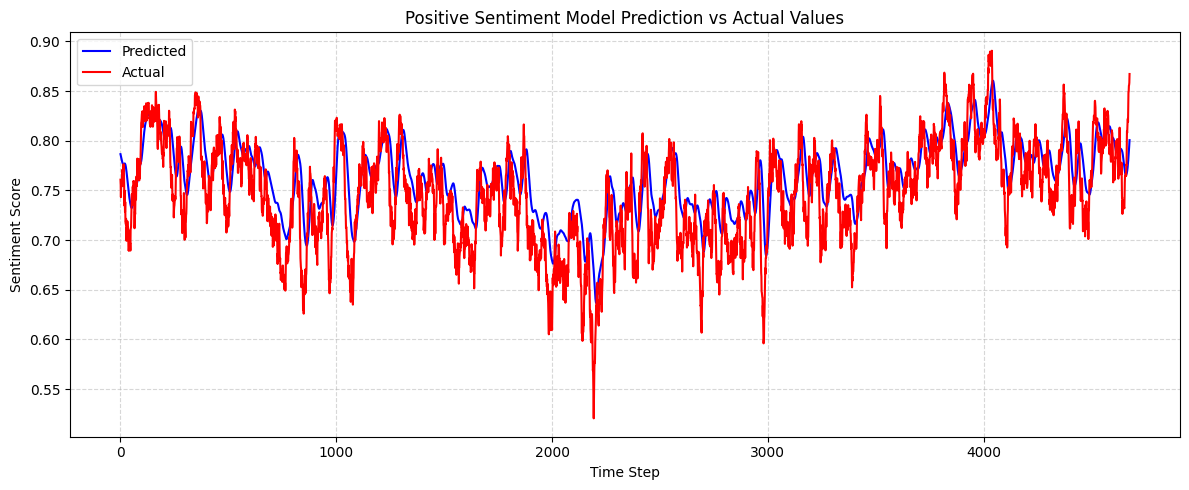

In [25]:
positive_sentiment.forecast_visual(positive_sentiment_model,text='Positive')

### Performing Model For Neutral sentiment

In [36]:
neutral_sentiment.df_to_X_y(new_df['moving_average_neu'])

100%|██████████| 16677/16677 [00:02<00:00, 7969.61it/s]


In [37]:
neutral_sentiment.split_data_points()

In [38]:
neutral_sentiment.train_stacked_lstm_model(learning_rate=0.001)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 180, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 180, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 180, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 180, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,473 (326.07 KB)

 Trainable params: 83,473 (326.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - loss: 9.1163e-04 - root_mean_squared_error: 0.0279 - val_loss: 2.5465e-04 - val_root_mean_squared_error: 0.0160
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 25s 84ms/step - loss: 1.7414e-04 - root_mean_squared_error: 0.0132 - val_loss: 1.0733e-04 - val_root_mean_squared_error: 0.0104
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - loss: 1.2586e-04 - root_mean_squared_error: 0.0112 - val_loss: 8.8015e-05 - val_root_mean_squared_error: 0.0094
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 25s 84ms/step - loss: 9.0584e-05 - root_mean_squared_error: 0.0095 - val_loss: 6.6864e-05 - val_root_mean_squared_error: 0.0082
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - loss: 7.5272e-05 - root_mean_squared_error: 0.0087 - val_loss: 7.4476e-05 - val_root_mean_squared_error: 0.0086
Epoch 5: early stopping


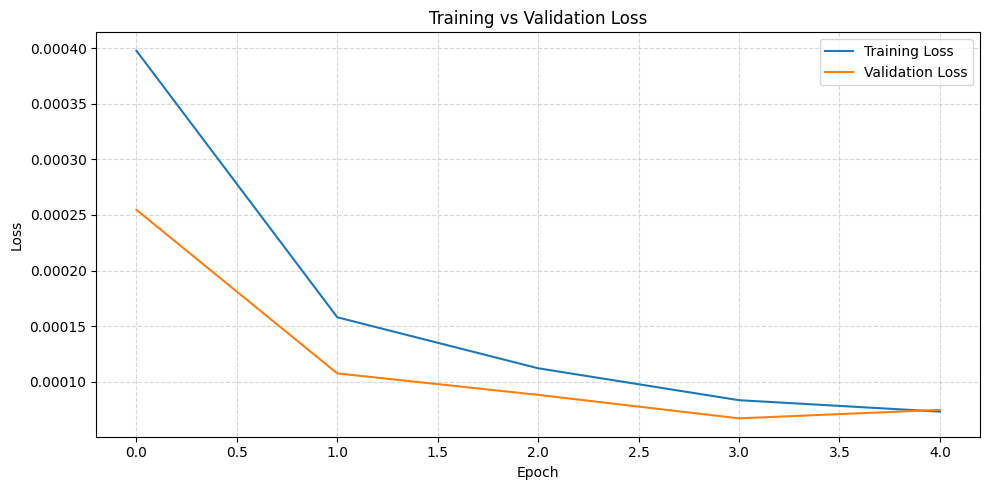

In [39]:
neutral_sentiment.fit_model()

In [40]:
neutral_sentiment_model = neutral_sentiment.forecast_model()

147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step


In [41]:
neutral_sentiment.evaluation(neutral_sentiment_model)

mse :  0.0001046439750116639
rmse :  0.010229563774260557
r2 :  0.7914769541111407
mae :  0.008253560164198178


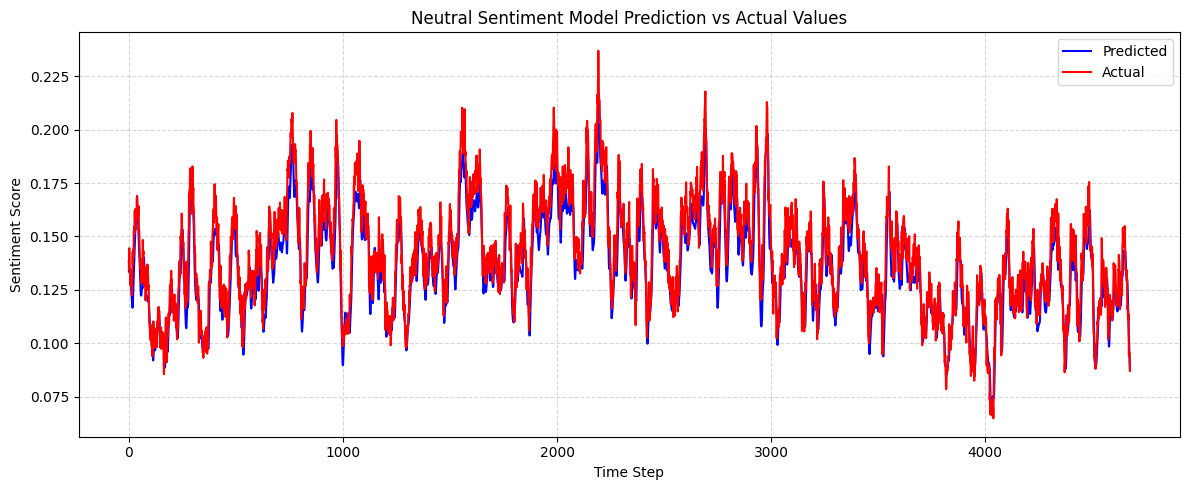

In [42]:
neutral_sentiment.forecast_visual(neutral_sentiment_model,text='Neutral')

In [34]:
positive_score = 1 - negative_sentiment_model['Test Prediction'] - neutral_sentiment_model['Test Prediction']

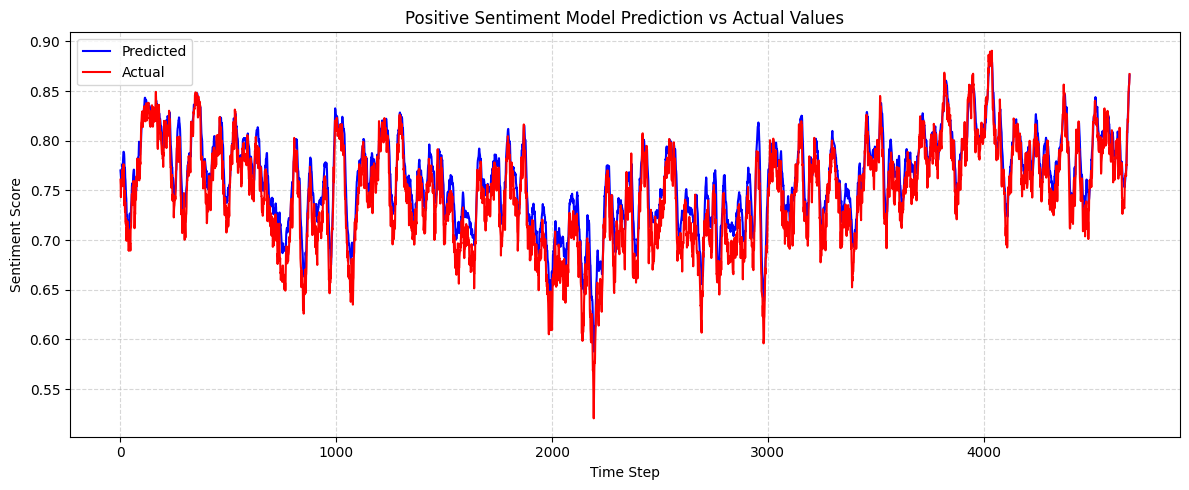

In [44]:
plt.figure(figsize=(12, 5))

plt.plot(positive_score, color='blue', label='Predicted')
plt.plot(positive_sentiment_model['Actual'], color='red', label='Actual')
plt.title('Positive Sentiment Model Prediction vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [45]:
mse = mean_squared_error(positive_score,positive_sentiment_model['Actual'])
rmse = np.sqrt(mse)
r2 = r2_score(positive_score,positive_sentiment_model['Actual'])
mae = mean_absolute_error(positive_score,positive_sentiment_model['Actual'])

print('mse : ',mse)
print('rmse : ',rmse)
print('r2 : ',r2)
print('mae : ',mae)

mse :  0.0005181586530854252
rmse :  0.02276309849483205
r2 :  0.7263497347341467
mae :  0.01875412317116206
